### 1. Load Libraries

In [8]:
import spacy
import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

### 2. Import NewsGroups Dataset

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


### 3. Tokenize Sentences and Clean

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]



[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

### 4. Build the Bigram, Trigram Models and Lemmatize

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### 5. Build the Topic Model

To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [10]:
#slow!!
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.016*"team" + 0.016*"game" + 0.011*"hockey" + 0.009*"nhl" + 0.008*"bike" + '
  '0.008*"player" + 0.008*"organization" + 0.008*"play" + 0.008*"win" + '
  '0.007*"hawk"'),
 (1,
  '0.010*"christian" + 0.008*"question" + 0.008*"write" + 0.008*"believe" + '
  '0.008*"law" + 0.007*"book" + 0.007*"organization" + 0.007*"claim" + '
  '0.006*"people" + 0.006*"article"'),
 (2,
  '0.013*"time" + 0.009*"tell" + 0.009*"people" + 0.009*"god" + 0.008*"write" '
  '+ 0.007*"well" + 0.006*"work" + 0.006*"organization" + 0.006*"give" + '
  '0.006*"look"'),
 (3,
  '0.027*"armenian" + 0.014*"israel" + 0.012*"israeli" + 0.008*"state" + '
  '0.008*"government" + 0.007*"turk" + 0.007*"center" + 0.007*"genocide" + '
  '0.007*"article" + 0.007*"arab"')]


### 6. What is the dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.6516,"team, game, hockey, nhl, bike, player, organiz...","[irwin, arnstein, recommendation, duc, summary..."
1,1,2.0,0.6697,"time, tell, people, god, write, well, work, or...","[eric, townsend, insurance, lotsa_point, reply..."
2,2,0.0,0.5611,"team, game, hockey, nhl, bike, player, organiz...","[gary_dare, reply, gary_dare, organization, ph..."
3,3,3.0,0.5947,"armenian, israel, israeli, state, government, ...","[naftaly_stramer, peace_talk, reply, organizat..."
4,4,1.0,0.5864,"christian, question, write, believe, law, book...","[question, authority, trendy, liberal, feminis..."
5,5,2.0,0.8599,"time, tell, people, god, write, well, work, or...","[harrasse, work, prayer, reply, organization, ..."
6,6,2.0,0.5493,"time, tell, people, god, write, well, work, or...","[andrew_infante, little_hasty, organization, d..."
7,7,2.0,0.7148,"time, tell, people, god, write, well, work, or...","[james_sledd, afterlife, organization, social,..."
8,8,2.0,0.5023,"time, tell, people, god, write, well, work, or...","[canadien, stanley_cup, organization, canada, ..."
9,9,0.0,0.9018,"team, game, hockey, nhl, bike, player, organiz...","[steve_gallichio, possible, canadian, wc, team..."


### 7. Word Clouds of Top N Keywords in Each Topic

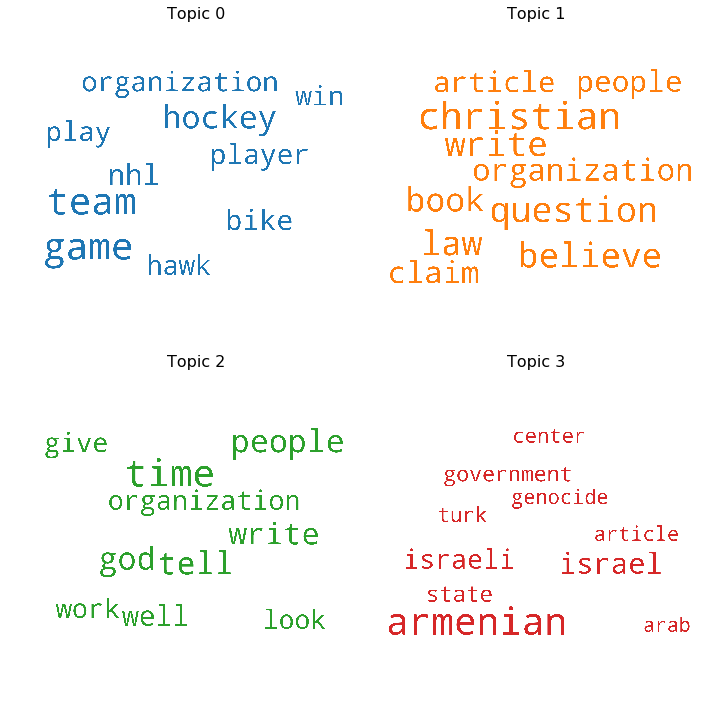

In [12]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 8. Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

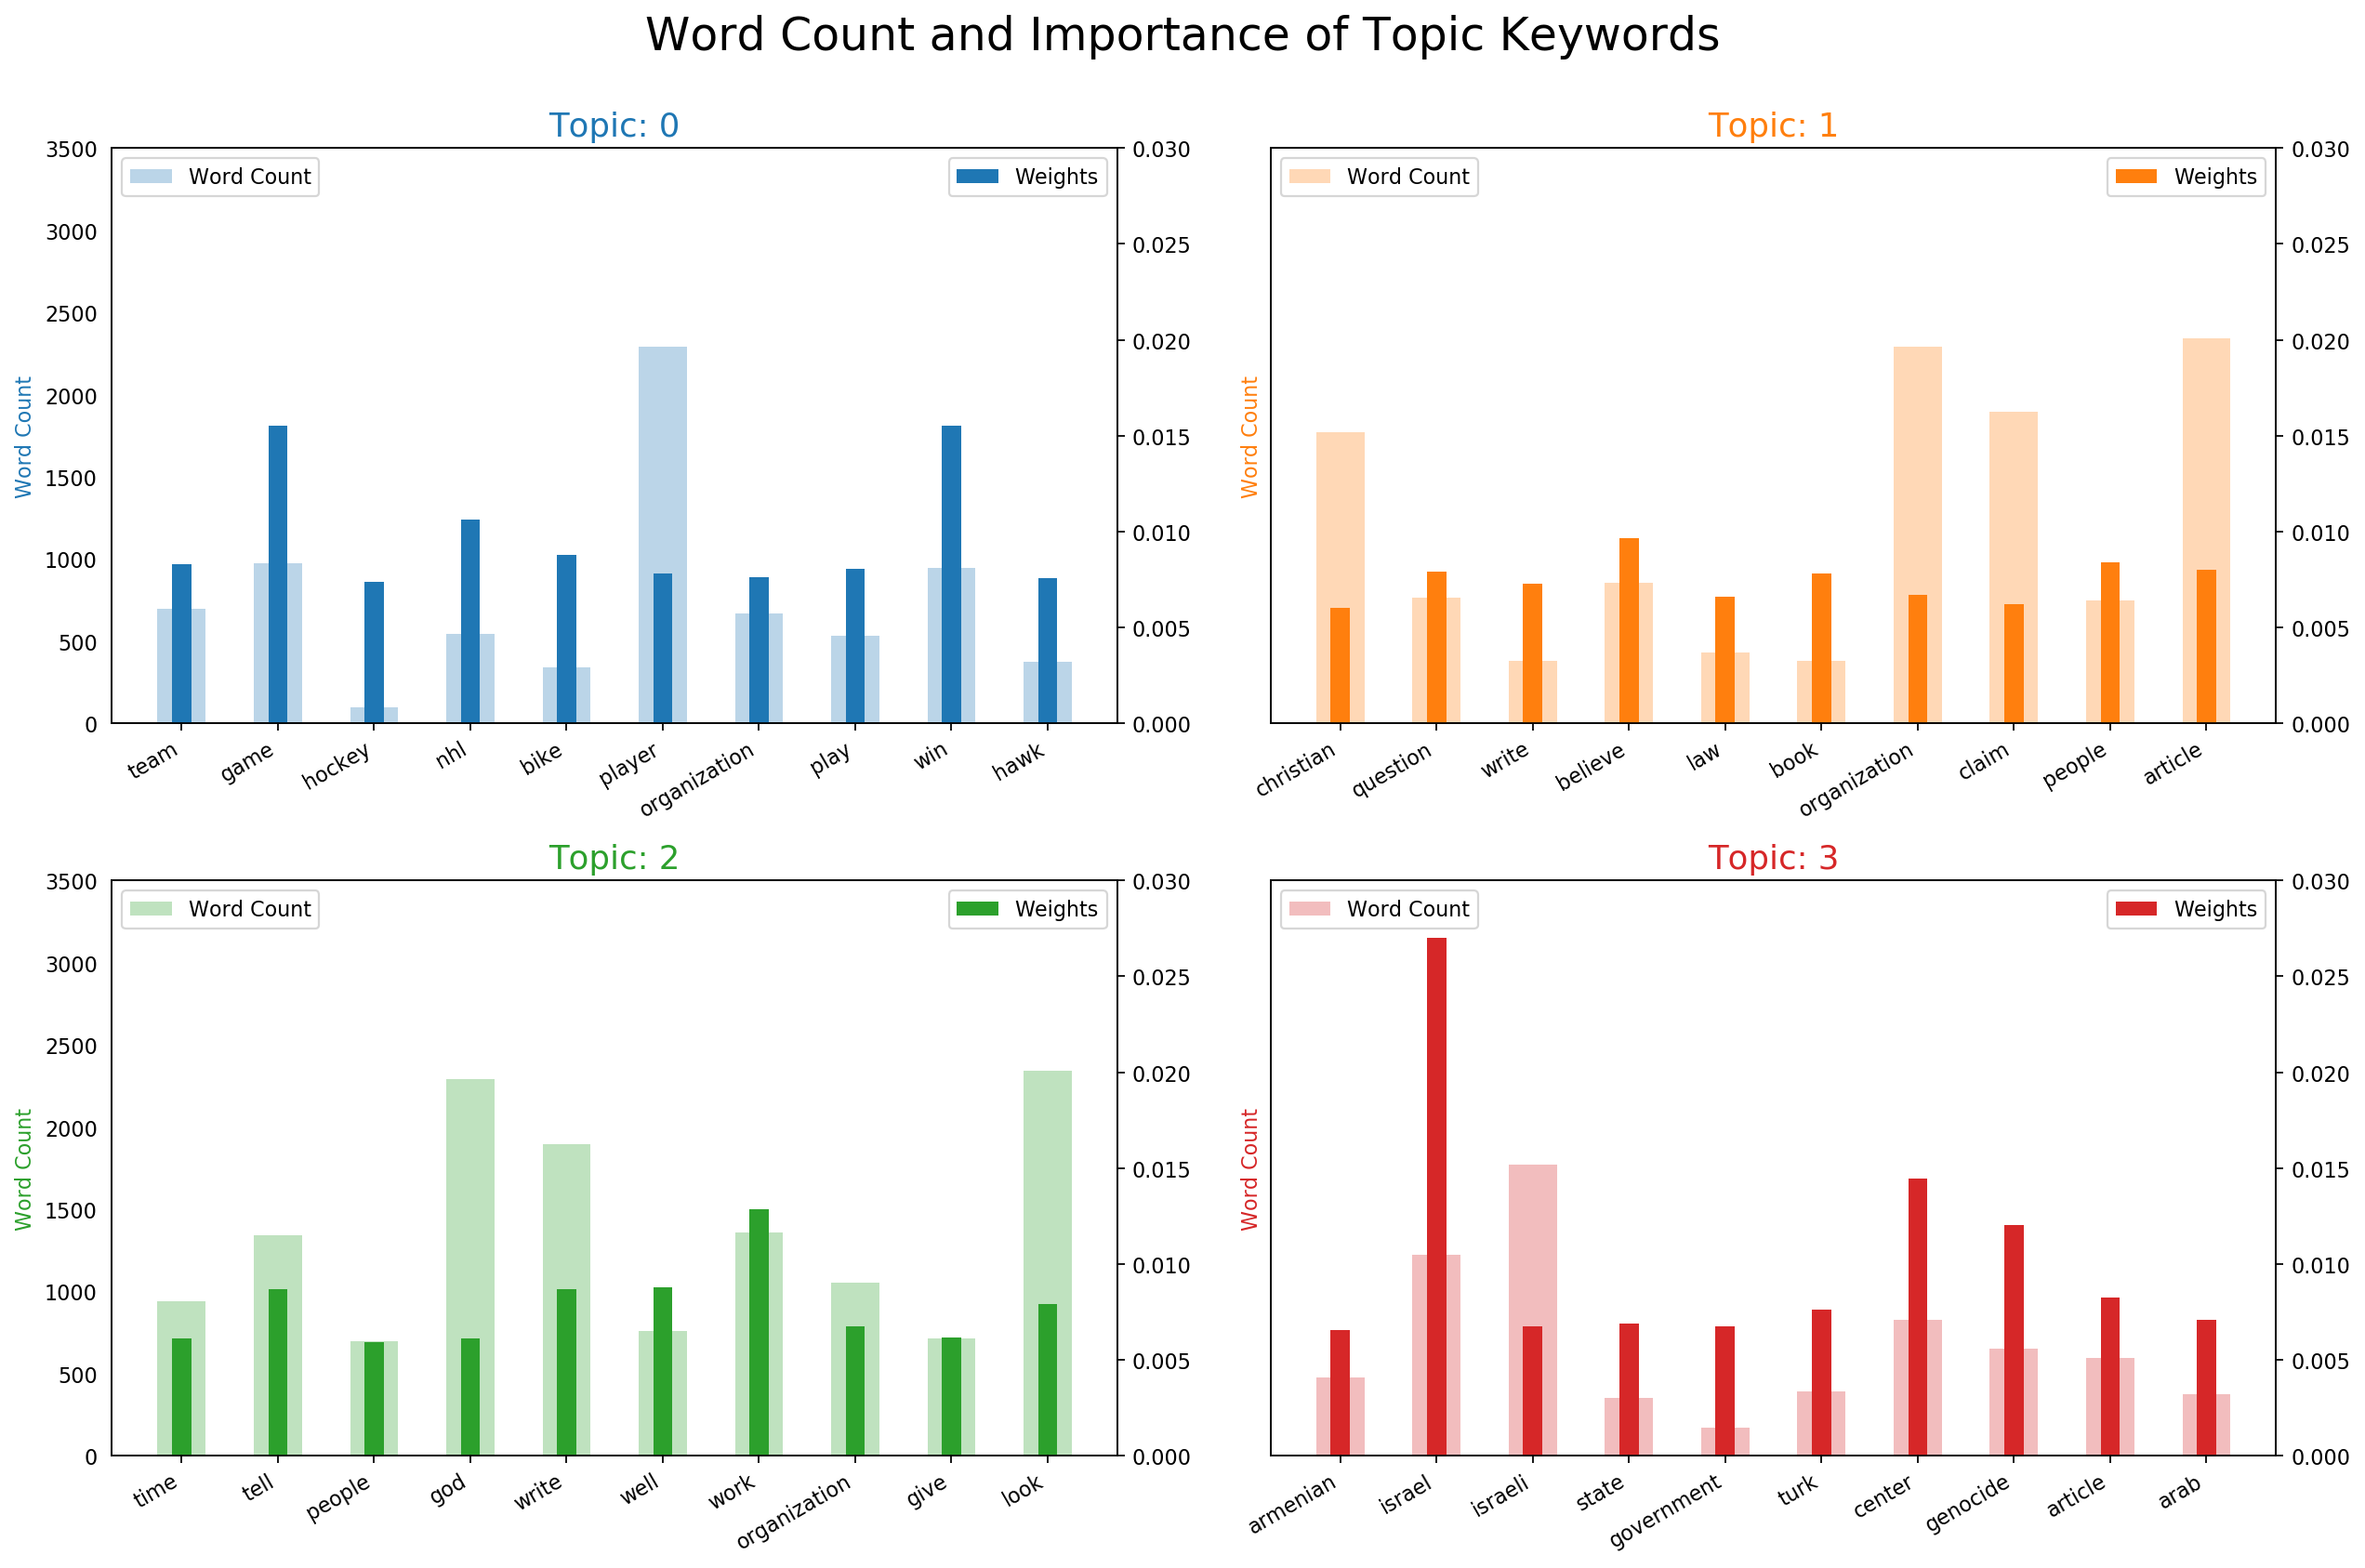

In [13]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 9. What are the most discussed topics in the documents?

Let’s compute the total number of documents attributed to each topic.

In [15]:
# Helper Functions and dataframes
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

make the plots:

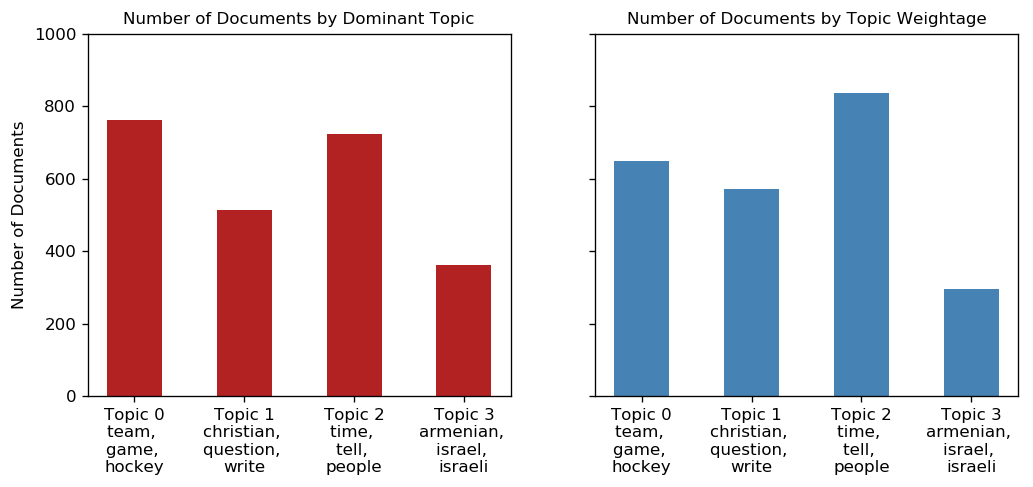

In [16]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### 10. pyLDAVis

Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

### Tasks in Class

Suppose a vandal has broken into your study and torn apart four of your books:

* *Great Expectations* by Charles Dickens
* *The War of the Worlds* by H.G. Wells
* *Twenty Thousand Leagues Under the Sea* by Jules Verne
* *Pride and Prejudice* by Jane Austen

This vandal has torn the books into individual chapters, and left them in one large pile. How can we restore these disorganized chapters to their original books? This is a challenging problem since the individual chapters are unlabeled: we don’t know what words might distinguish them into groups. We’ll thus use topic modeling to discover how chapters cluster into distinct topics, each of them (presumably) representing one of the books.
The code below loads the chapters of the four books and returns a corpus

In [17]:
%run "CorpusUtils.py"
books = makeCleanCorpus(abspath = os.path.abspath('.') + '/data/LibraryHeist/')

Cleaning: GEx_1.txt
Cleaning: GEx_2.txt
Cleaning: GEx_3.txt
Cleaning: GEx_4.txt
Cleaning: GEx_5.txt
Cleaning: GE_10.txt
Cleaning: GE_11.txt
Cleaning: GE_12.txt
Cleaning: GE_13.txt
Cleaning: GE_14.txt
Cleaning: GE_15.txt
Cleaning: GE_16.txt
Cleaning: GE_17.txt
Cleaning: GE_18.txt
Cleaning: GE_19.txt
Cleaning: GE_20.txt
Cleaning: GE_21.txt
Cleaning: GE_22.txt
Cleaning: GE_23.txt
Cleaning: GE_24.txt
Cleaning: GE_25.txt
Cleaning: GE_26.txt
Cleaning: GE_27.txt
Cleaning: GE_28.txt
Cleaning: GE_29.txt
Cleaning: GE_30.txt
Cleaning: GE_31.txt
Cleaning: GE_32.txt
Cleaning: GE_33.txt
Cleaning: GE_34.txt
Cleaning: GE_35.txt
Cleaning: GE_36.txt
Cleaning: GE_37.txt
Cleaning: GE_38.txt
Cleaning: GE_39.txt
Cleaning: GE_40.txt
Cleaning: GE_41.txt
Cleaning: GE_42.txt
Cleaning: GE_43.txt
Cleaning: GE_44.txt
Cleaning: GE_45.txt
Cleaning: GE_46.txt
Cleaning: GE_47.txt
Cleaning: GE_48.txt
Cleaning: GE_49.txt
Cleaning: GE_50.txt
Cleaning: GE_51.txt
Cleaning: GE_52.txt
Cleaning: GE_53.txt
Cleaning: GE_54.txt
